In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
#csv_file = "data/bmarksgame/measurements_5_1.csv"
csv_file = "data/bmarksgame/measurements_17_4_19_st.csv"
raw_df = pd.read_csv( csv_file )

In [6]:
# Tuples of (benchmark, lang, id)
illegal_runs = [ ("chameneosredux", "pycket", 1),
                 ("chameneosredux", "pycket", 2),
                 ("fannkuchredux",  "pycket", 3),
                 ("knucleotide",    "pycket", 1),
                 ("knucleotide",    "pycket", 4),             
                 ("mandelbrot",     "pycket", 4),
                 ("pidigits",       "pycket", 2),
                 ("regexdna",       "pycket", 1),
                 ("spectralnorm",   "pycket", 3),
                 ("threadring",     "pycket", 1),                          
               ]

# To make it more compatible, also remove other interpreters that use this.
more_illegal_runs = []
for bmark, lang, id_ in illegal_runs:
    if lang == "pycket":
        more_illegal_runs.append( (bmark, "racket", id_) )

In [5]:
# Remove illegal runs. Note row.name has a special meaning, so using row["name"].
# apply() applies function over on all rows (axis=1), and [] operator accepts a bool
# series to select only those entries which are true.
df = raw_df[ raw_df.apply( lambda r: (r["name"], r.lang, r.id) not in illegal_runs, axis=1 ) ]
#strict_df = raw_df[ raw_df.apply( lambda r: (r["name"], r.lang, r.id) not in 
#                                 ( illegal_runs + more_illegal_runs ), axis=1 ) ]

In [6]:
# For C/C++, find the fastest in either
df_ccpp = df[(df.lang == "gcc") | (df.lang == "gpp")].sort_values(by="elapsed(s)") \
          .groupby("name", as_index=False).first()

# add 100 if c++
df_ccpp["id"] = df_ccpp.apply( lambda r: r["id"] + (0 if r["lang"] == "gcc" else 100), axis=1 )
df_ccpp["lang"] = "c/c++"

In [7]:
def get_rpython_df( lang1, lang2 ):
    
    _df = df[(df.lang == lang1) | (df.lang == lang2)].sort_values(by="elapsed(s)")
    fast_dict = {}
    for i, r in _df.iterrows():
        bmark = r["name"]
        if bmark in fast_dict:
            continue
        
        # skip id >= 20 variants
        if r.id >= 20:
            continue
            
        def both_langs_have_results():
            return len( df[(df.lang == lang1) & (df["name"] == bmark)] ) > 0 and \
                   len( df[(df.lang == lang2) & (df["name"] == bmark)] ) > 0
        def both_langs_have_results_id( id_ ):
            return len( df[(df.lang == lang1) & (df["name"] == bmark) & (df["id"] == id_)] ) > 0 and \
                   len( df[(df.lang == lang2) & (df["name"] == bmark) & (df["id"] == id_)] ) > 0

        if not both_langs_have_results() or both_langs_have_results_id( r.id ):
            # If both languages don't have results for this benchmark, 
            # or they have results for this id, just take this.
            fast_dict[bmark] = r.id

    # For Python, find the fastest in any implementation and use that.
    #df_fastest = df[(df.lang == lang1) | (df.lang == lang2)] \
    #        .sort_values(by="elapsed(s)").groupby("name").first()
    #print fast_dict
    return df[ df.apply( lambda r: (fast_dict[ r["name"] ] == r.id) &
             ( (r.lang == lang1) | (r.lang == lang2) ), axis=1 ) ]


In [8]:
df_py = get_rpython_df("python", "pypy")

df_rkt = get_rpython_df("pycket", "racket")

df_fast = df_ccpp.append( df_py ).append( df_rkt )

In [9]:
df_pivot = pd.pivot_table(df_fast.sort_values(by="name"),
               values=["elapsed(s)", "id"], index=["name"], columns=["lang"])
df_pivot

elapsed(s)                                           id         \
lang                c/c++   pycket      pypy    python   racket  c/c++ pycket   
name                                                                            
binarytrees         3.006   35.018    13.662   112.711   17.146    3.0    1.0   
chameneosredux      1.079      NaN  1483.099    94.606  120.674  102.0    NaN   
fannkuchredux      19.226  138.586   493.474  1719.473  262.592  107.0    2.0   
fasta              11.520   24.341    64.108    96.003   22.805    6.0    3.0   
knucleotide        15.974      NaN   141.036   240.448   71.020  103.0    NaN   
mandelbrot          7.407   49.392   218.493   858.668   66.723    5.0    3.0   
meteor              0.063    1.975     1.929     4.952    0.776  106.0    1.0   
nbody               7.648   21.642    95.364   747.729   40.765    4.0    2.0   
pidigits            1.504   11.102     7.664     2.645   19.671  104.0    1.0   
regexdna            4.938      NaN    15.443    18.869   33.260  101.0    NaN   
revcomp             2.764   11.065    18.667    11.135   14.041    1.0    2.0   
spectralnorm        5.056   21.474    51.618   526.635   32.540    5.0    1.0   
threadring          4.772      NaN    80.406    99.090   79.959  105.0    NaN   

                                   
lang           pypy python racket  
name                               
binarytrees     2.0    2.0    1.0  
chameneosredux  2.0    2.0    2.0  
fannkuchredux   6.0    6.0    2.0  
fasta           2.0    2.0    3.0  
knucleotide     8.0    8.0    4.0  
mandelbrot      7.0    7.0    3.0  
meteor          2.0    2.0    1.0  
nbody           2.0    2.0    2.0  
pidigits        2.0    2.0    1.0  
regexdna        5.0    5.0    1.0  
revcomp         6.0    6.0    2.0  
spectralnorm    5.0    5.0    1.0  
threadring      2.0    2.0    1.0

In [10]:
import math
def format_lg( val ):
    if val >= 10.0:
        return int(val)
    else:
        return "{:0.1f}".format( val )
        
cols = ["c/c++", "python", "pypy", "racket", "pycket"]
normalize_by = "c/c++"
for b, r in df_pivot.iterrows():
    norm_val = r["elapsed(s)"][normalize_by]
    print "{} ".format( b ),
    for c in cols:
        val = r["elapsed(s)"][c]
        if math.isnan(val):
            print "& -- & -- ",
        else:
            if c != normalize_by:
                print "& {} ".format( format_lg( r["elapsed(s)"][c] / norm_val ) ) ,
            # find the ipc
            lang = c
            id_ = r["id"][c]
            if lang == "c/c++":
                if id_ >= 100:
                    id_ = id_ - 100
                    lang = "gpp"
                else:
                    lang = "gcc"
            
            perf_row = overall[(overall.id == id_) & (overall.lang == lang) & 
                               (overall.benchmark == b)].iloc[0]
            # ipc
            print "& {:.2f} ".format( perf_row.instructions / perf_row.cycles ),
    print " \\\\"

binarytrees 

NameError: name 'overall' is not defined

In [11]:
df_pivot.loc["binarytrees"]

            lang  
elapsed(s)  c/c++       3.006
            pycket     35.018
            pypy       13.662
            python    112.711
            racket     17.146
id          c/c++       3.000
            pycket      1.000
            pypy        2.000
            python      2.000
            racket      1.000
Name: binarytrees, dtype: float64

In [12]:
df_pivot

elapsed(s)                                           id         \
lang                c/c++   pycket      pypy    python   racket  c/c++ pycket   
name                                                                            
binarytrees         3.006   35.018    13.662   112.711   17.146    3.0    1.0   
chameneosredux      1.079      NaN  1483.099    94.606  120.674  102.0    NaN   
fannkuchredux      19.226  138.586   493.474  1719.473  262.592  107.0    2.0   
fasta              11.520   24.341    64.108    96.003   22.805    6.0    3.0   
knucleotide        15.974      NaN   141.036   240.448   71.020  103.0    NaN   
mandelbrot          7.407   49.392   218.493   858.668   66.723    5.0    3.0   
meteor              0.063    1.975     1.929     4.952    0.776  106.0    1.0   
nbody               7.648   21.642    95.364   747.729   40.765    4.0    2.0   
pidigits            1.504   11.102     7.664     2.645   19.671  104.0    1.0   
regexdna            4.938      NaN    15.443    18.869   33.260  101.0    NaN   
revcomp             2.764   11.065    18.667    11.135   14.041    1.0    2.0   
spectralnorm        5.056   21.474    51.618   526.635   32.540    5.0    1.0   
threadring          4.772      NaN    80.406    99.090   79.959  105.0    NaN   

                                   
lang           pypy python racket  
name                               
binarytrees     2.0    2.0    1.0  
chameneosredux  2.0    2.0    2.0  
fannkuchredux   6.0    6.0    2.0  
fasta           2.0    2.0    3.0  
knucleotide     8.0    8.0    4.0  
mandelbrot      7.0    7.0    3.0  
meteor          2.0    2.0    1.0  
nbody           2.0    2.0    2.0  
pidigits        2.0    2.0    1.0  
regexdna        5.0    5.0    1.0  
revcomp         6.0    6.0    2.0  
spectralnorm    5.0    5.0    1.0  
threadring      2.0    2.0    1.0

In [97]:
df_fast.groupby(["name", "lang"], as_index=False).first()

,name,lang,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s)
0,binarytrees,gpp,3,14,1214,0.035,0,0,%,0.044
1,binarytrees,pycket,1,14,621,1.377,0,0,%,1.765
2,binarytrees,pypy,1,14,708,0.452,0,0,%,0.507
3,binarytrees,python,1,14,708,1.500,0,0,%,1.575
4,binarytrees,racket,1,14,621,0.339,0,0,%,0.384
5,chameneosredux,gpp,2,600000,2357,0.000,0,-10,%,0.147
6,chameneosredux,pypy,2,600000,1192,21.388,0,0,%,148.832
7,chameneosredux,python,2,600000,1192,0.000,0,-10,%,10.241
8,chameneosredux,racket,2,600000,987,0.000,0,-10,%,13.283
9,fannkuchredux,gpp,7,10,1898,0.161,0,0,%,0.170


In [11]:
df.sort_values(by="elapsed(s)").groupby(["name", "lang"]).first()

id        n  size(B)  cpu(s)  mem(KB)  status load  \
name           lang                                                          
binarytrees    gcc       3       14     1826   0.046        0       0    %   
               gpp       3       14     1214   0.035        0       0    %   
               pycket    1       14      621   1.377        0       0    %   
               pypy      1       14      708   0.452        0       0    %   
               python    2       14      466   1.281        0       0    %   
               python3   2       14      465   1.420        0       0    %   
               racket    1       14      621   0.339        0       0    %   
chameneosredux gcc       2   600000     1916   0.000        0     -10    %   
               gpp       2   600000     2357   0.000        0     -10    %   
               pypy      2   600000     1192  21.388        0       0    %   
               python    2   600000     1192   0.000        0     -10    %   
               python3   2   600000     1191   0.000        0     -10    %   
               racket    2   600000      987   0.000        0     -10    %   
fannkuchredux  gcc       4       10     1936   0.199        0       0    %   
               gpp       7       10     1898   0.161        0       0    %   
               pycket    2       10     1141   2.224        0       0    %   
               pypy      6       10      552   2.416        0       0    %   
               python    6       10      552  10.479        0       0    %   
               python3   4       10     1069  10.889        0       0    %   
               racket    2       10     1141   2.027        0       0    %   
fasta          gcc       5  2500000     2444   0.460        0       0    %   
               gpp       2  2500000     1260   0.340        0       0    %   
               pycket    3  2500000     1453   2.643        0       0    %   
               pypy      2  2500000     1917   3.483        0       0    %   
               python    3  2500000     1702   9.586        0       0    %   
               python3   3  2500000     1647  10.148        0       0    %   
               racket    3  2500000     1453   1.796        0       0    %   
knucleotide    gcc       1    10000     2693   0.000        0     -10    %   
               gpp       3    10000     1373   0.000        0     -10    %   
               pypy     21    10000      593   0.000        0     -10    %   
...                     ..      ...      ...     ...      ...     ...  ...   
pidigits       pypy     22     1000      388   0.000        0      -2    %   
               python   24     1000      378   0.028        0       0    %   
               python3   2     1000      493   0.000        0      -2    %   
               racket    1     1000      573   0.276        0       0    %   
regexdna       gcc       4    10000     1833   0.063        0       0    %   
               gpp       2    10000      769   0.016        0       0    %   
               pypy      5    10000      528   0.199        0       0    %   
               python   25    10000      528   0.083        0       0    %   
               python3   5    10000      524   0.130        0       0    %   
               racket    1    10000      707   0.432        0       0    %   
revcomp        gcc       1     1000     1949   0.002        0       0    %   
               gpp       3     1000      881   0.005        0       0    %   
               pycket    2     1000     1130   0.980        0       0    %   
               pypy     23     1000      448   0.057        0       0    %   
               python   25     1000      456   0.031        0       0    %   
               python3   4     1000      449   0.053        0       0    %   
               racket    1     1000      628   0.112        0       0    %   
spectralnorm   gcc       5      550      729   0.086        0       0    %   
               gpp       5      550     1345  

In [13]:
df_pivot = pd.pivot_table(df.sort_values(by="elapsed(s)").groupby(["name", "lang"]).first(),
               values=["id", "elapsed(s)"], index=["name"], columns=["lang"])
df_pivot

elapsed(s)                                                  id  \
lang                  gcc    gpp pycket     pypy  python python3  racket  gcc   
name                                                                            
binarytrees         0.073  0.044  1.765    0.507   1.337   1.468   0.384  3.0   
chameneosredux      0.895  0.147    NaN  148.832  10.241  15.912  13.283  2.0   
fannkuchredux       0.216  0.170  2.592    2.454  10.601  10.953   2.100  4.0   
fasta               0.808  0.671  3.378    3.798  10.007  10.504   2.223  5.0   
knucleotide         0.043  0.079    NaN    0.188   0.242   0.296   0.457  1.0   
mandelbrot          0.056  0.045  1.559    0.126   1.733   3.697   0.734  5.0   
meteor              0.030  0.051  1.983    1.251   2.002   2.240   0.535  1.0   
nbody               1.005  0.929  3.482    5.236  76.013  72.442   4.717  4.0   
pidigits            0.051  0.028  1.517    0.116   0.068   0.174   0.321  1.0   
regexdna            0.082  0.024    NaN    0.242   0.121   0.161   0.570  4.0   
revcomp             0.009  0.014  1.327    0.103   0.071   0.102   0.153  1.0   
spectralnorm        0.105  0.134  1.624    0.122   0.506   7.045   0.547  5.0   
threadring          7.380  0.610    NaN    0.191   0.902  11.930   8.173  2.0   

                                                        
lang            gpp pycket  pypy python python3 racket  
name                                                    
binarytrees     3.0    1.0   1.0    2.0     2.0    1.0  
chameneosredux  2.0    NaN   2.0    2.0     2.0    2.0  
fannkuchredux   7.0    2.0   6.0    6.0     4.0    2.0  
fasta           2.0    3.0   2.0    3.0     3.0    3.0  
knucleotide     3.0    NaN  21.0   21.0     3.0    1.0  
mandelbrot      6.0    2.0  26.0   26.0     7.0    2.0  
meteor          1.0    1.0  22.0    2.0     3.0    1.0  
nbody           3.0    2.0   2.0    1.0     1.0    2.0  
pidigits        4.0    1.0  22.0   24.0     2.0    1.0  
regexdna        2.0    NaN   5.0   25.0     5.0    1.0  
revcomp         3.0    2.0  23.0   25.0     4.0    1.0  
spectralnorm    5.0    1.0  22.0   22.0     6.0    3.0  
threadring      5.0    NaN  21.0   21.0     2.0    1.0

In [28]:
for b, r in df_pivot.iterrows():
    pypy_id = int(r["id"]["pypy"])
    cpython_id = int(r["id"]["python"])

    if pypy_id != cpython_id:
        print "mismatch in {}: pypy is {} cpython is {}".format( b, pypy_id, cpython_id )
        print pypy_id, df[ ( (df.lang == "pypy") | (df.lang == "python") ) & (df.name == b) &
                           ( (df.id == pypy_id) | (df.id == cpython_id) )] \
                          .drop(["n", "size(B)", "cpu(s)", "mem(KB)", "load"], axis=1) \
                          .sort_values(by=["lang", "id"])
 
    try:
        pycket_id = int(r["id"]["pycket"])
        racket_id = int(r["id"]["racket"])
    except ValueError:
        continue
    if pycket_id != racket_id:
        print "mismatch in {}: pycket is {} racket is {}".format( b, pycket_id, racket_id )
        print pypy_id, df[ ( (df.lang == "pycket") | (df.lang == "racket") ) & (df.name == b) &
                           ( (df.id == pycket_id) | (df.id == racket_id) )] \
                        .drop(["n", "size(B)", "cpu(s)", "mem(KB)", "load"], axis=1) \
                        .sort_values(by=["lang", "id"])

mismatch in binarytrees: pypy is 1 cpython is 2
1            name    lang  id  status  elapsed(s)
10  binarytrees    pypy   1       0       0.507
19  binarytrees    pypy   2       0       0.581
17  binarytrees  python   1       0       1.575
5   binarytrees  python   2       0       1.337
mismatch in fasta: pypy is 2 cpython is 3
2      name    lang  id  status  elapsed(s)
61  fasta    pypy   2       0       3.798
83  fasta    pypy   3       0       3.925
60  fasta  python   2       0      10.827
75  fasta  python   3       0      10.007
mismatch in meteor: pypy is 22 cpython is 2
22        name    lang  id  status  elapsed(s)
142  meteor    pypy   2       0       1.309
153  meteor    pypy  22       0       1.251
161  meteor  python   2       0       2.002
143  meteor  python  22       0       2.084
mismatch in nbody: pypy is 2 cpython is 1
2       name    lang  id  status  elapsed(s)
170  nbody    pypy   1       0      10.704
178  nbody    pypy   2       0       5.236
180  nbody  pyth

## Perf

In [2]:
# TODO: I don't know what the last two columns are, hence dk.
perf_col_names = ["time", "counts", "units", "events", "dk1", "dk2"]

In [3]:
# From the filename, return the raw dataframe and overall statistics.
def process_csv( filename ):
    # Skip first two rows because they don't contain data.
    raw = pd.read_csv( filename, header=None, names=perf_col_names, skiprows=2 )
    # Get elapsed by getting the last entry.
    elapsed = raw.iloc[-1].time
    if raw.counts.dtype != "int64":
        # Missing data are represented with "<not counted>". Drop those.
        raw = raw[ raw.counts != "<not counted>" ]
        raw.counts = raw.counts.astype( int )
    #replace them with NaNs.
    #raw = raw.replace("<not counted>", np.nan)
    # The <not counted> turns the row into string, and that fails in sum(), so convert to int.
    #raw.counts = raw.counts.astype( int )
    # Getting the total execution time and various metrics.
    rawgb = raw.groupby( "events" ).sum()
    instructions = rawgb.loc["instructions"].counts
    cycles = rawgb.loc["cycles"].counts
    branches = rawgb.loc["branches"].counts
    branch_misses = rawgb.loc["branch-misses"].counts
    return raw, elapsed, instructions, cycles, branches, branch_misses

In [4]:
# Convert csv file name to benchmark, lang, id tuple.
def csv2impl( csv_name ):
    tokens = csv_name.split( "." )
    assert tokens[-1] == "csv", tokens
    lang = tokens[-2].replace( "_run", "" )
    benchmark = tokens[0]
    if len( tokens ) == 4:
        lang2, id_ = tokens[1].split( "-" )
        assert lang2 == lang, tokens
        id_ = int( id_ )
    else:
        assert len( tokens ) == 3
        id_ = 1
    return benchmark, lang, id_   

In [7]:
# Create a dataframe with the overall statistics.
overall = pd.DataFrame( columns=[ "benchmark", "lang", "id", "elapsed", 
                                  "instructions", "cycles", "branches", "branch-misses"] )
raw_dfs = {}

perf_dir = "data/bmarksgame/bmarksgame_out/"
# Read all valid files and create the overall df and raw dfs.
for filename in os.listdir( perf_dir ):
    benchmark, lang, id_ = csv2impl( filename )
    impl = (benchmark, lang, id_)
    if impl in illegal_runs:
        continue
    try:
        raw_df, elapsed, instructions, cycles, branches, branch_misses = \
                process_csv( perf_dir + filename )
        raw_dfs[ impl ] = raw_df
        overall = overall.append( { "benchmark" : benchmark, "lang" : lang, "id" : id_,
                                "elapsed" : elapsed, "instructions" : instructions,
                                "cycles" : cycles, "branches" : branches,
                                "branch-misses" : branch_misses }, ignore_index=True )
    except Exception as e:
        print "exception in {}: {}".format( filename, e )
        pass
    
# id should be int.
overall.id = overall.id.astype(int)

In [68]:
overall[((overall.lang == "gcc") | (overall.lang == "gpp")) & (overall.benchmark == "mandelbrot")]

,benchmark,lang,id,elapsed,instructions,cycles,branches,branch-misses
98,mandelbrot,gcc,2,32.727339,1.084344e+11,8.608291e+10,1.379776e+10,22952076.0
99,mandelbrot,gcc,3,17.806282,5.992274e+10,4.485156e+10,6.406343e+09,9973292.0
100,mandelbrot,gcc,4,17.204252,5.924670e+10,4.439138e+10,6.404628e+09,8490207.0
101,mandelbrot,gcc,5,7.127760,3.510404e+10,1.766099e+10,5.878834e+08,4246758.0
102,mandelbrot,gcc,6,6.600989,3.920444e+10,1.658178e+10,1.223584e+09,7145381.0
103,mandelbrot,gcc,7,17.006295,5.709689e+10,4.418234e+10,6.378674e+09,8056940.0
104,mandelbrot,gcc,8,14.885362,3.658135e+10,3.866536e+10,1.764271e+09,7881010.0
105,mandelbrot,gcc,9,16.514005,1.069679e+11,4.283047e+10,1.651493e+09,4834429.0
106,mandelbrot,gcc,1,17.590792,6.049995e+10,4.568122e+10,6.611725e+09,36115401.0
107,mandelbrot,gpp,2,33.953264,1.910016e+11,8.725338e+10,1.563249e+10,30328586.0


In [69]:

# skip chameneosredux (22), knucleotide (85), mandelbrot (101), and threadring (275) 
# because our pypy comparison doesn't have those
# 22, 85, 101, 275
ccpp_perf_df = overall.iloc[ [0, 41, 59, 138, 159, 183, 203, 219, 244 ] ]

In [70]:
ccpp_perf_df["ipc"] = ccpp_perf_df["instructions"] / ccpp_perf_df["cycles"]
ccpp_perf_df["br_per_inst"] = ccpp_perf_df["branches"] / ccpp_perf_df["instructions"]
ccpp_perf_df["br_mpki"] = ccpp_perf_df["branch-misses"] / ccpp_perf_df["instructions"] * 1000

/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [71]:
ccpp_perf_df

,benchmark,lang,id,elapsed,instructions,cycles,branches,branch-misses,ipc,br_per_inst,br_mpki
0,binarytrees,gcc,3,2.733975,1.540472e+10,7.143806e+09,2.672594e+09,12370377.0,2.156375,0.173492,0.803025
41,fannkuchredux,gpp,7,19.221122,5.887816e+10,5.094075e+10,8.876200e+09,634754291.0,1.155817,0.150755,10.780810
59,fasta,gcc,6,10.251452,1.685063e+10,8.939297e+09,2.687882e+09,3827464.0,1.885006,0.159512,0.227141
138,meteor,gpp,6,0.066843,1.257056e+08,1.062497e+08,1.760428e+07,2317549.0,1.183115,0.140044,18.436317
159,nbody,gcc,4,7.604576,4.502922e+10,2.020497e+10,1.855211e+09,72932.0,2.228621,0.041200,0.001620
183,pidigits,gpp,4,1.514978,6.543311e+09,3.967345e+09,3.908744e+08,862109.0,1.649292,0.059736,0.131754
203,regexdna,gpp,1,4.905917,1.757700e+10,1.296385e+10,4.547682e+09,154914359.0,1.355847,0.258729,8.813471
219,revcomp,gcc,1,15.869466,2.310275e+09,1.619990e+09,3.991992e+08,4898943.0,1.426104,0.172793,2.120502
244,spectralnorm,gcc,5,5.094467,1.605562e+10,1.334179e+10,6.090195e+08,270109.0,1.203408,0.037932,0.016823


In [72]:
ccpp_perf_df.mean()

id               4.111111e+00
elapsed          7.473644e+00
instructions     1.986385e+10
cycles           1.324756e+10
branches         2.450696e+09
branch-misses    9.047646e+07
ipc              1.582621e+00
br_per_inst      1.326882e-01
br_mpki          4.592385e+00
dtype: float64

In [73]:
ccpp_perf_df.std()

id               2.147350e+00
elapsed          6.531759e+00
instructions     1.961908e+10
cycles           1.548832e+10
branches         2.826388e+09
branch-misses    2.101890e+08
ipc              4.189100e-01
br_per_inst      7.325510e-02
br_mpki          6.606829e+00
dtype: float64

In [89]:
ccpp_perf_df.sem()

id               7.157833e-01
elapsed          2.177253e+00
instructions     6.539694e+09
cycles           5.162774e+09
branches         9.421294e+08
branch-misses    7.006301e+07
ipc              1.396367e-01
br_per_inst      2.441837e-02
br_mpki          2.202276e+00
dtype: float64

## PAPI

In [78]:
# Load all valid runs.
def load_papi( papi_dir, papi_impls ):
    df = pd.DataFrame()
    files = os.listdir( papi_dir )
    for bmark, id_ in papi_impls:
        if id_ == 1:
            papi_file = "{}.{}.csv".format( bmark, "python" )
        else:
            papi_file = "{}.{}-{}.{}.csv".format( bmark, "python", id_, "python" )
        #assert papi_file in files
        if papi_file not in files:
            print "{} not in {}".format( papi_file, files )
            assert False
    #for papi_file in files:
        if not papi_file.endswith(".csv"):
            continue
        run = papi_file[:-len(".csv")]
        tmp_df = pd.read_csv( papi_dir + papi_file)
        tmp_df["run"] = bmark # run
        df = df.append( tmp_df, ignore_index=True )
    return df


In [50]:
papi_dir = "data/bmarksgame/papi_out/"

In [64]:
# list of pypy impls
papi_impls = [ ("binarytrees",    2),
               #("chameneosredux", 2),
               ("fannkuchredux",  6),
               ("fasta",          2),
               #("knucleotide",    8),
               #("mandelbrot",     7),
               ("meteor",         2),
               ("nbody",          2),
               ("pidigits",       2),
               ("regexdna",       5),
               ("revcomp",        6),
               ("spectralnorm",   6),
               #("threadring",     2),
             ]

In [79]:
papi_df = load_papi( papi_dir, papi_impls )

In [75]:
# G = major collection, g = minor collection. T = tracing for bridges, t = tracing for loops. 
# Lump these together for now.
phase_begins = {
    110: "b",
    #120: "G",
    120: "g",
    122: "g",
    130: "t",
    #132: "T",
    132: "t",
    160: "j",
}
phase_ends = {
    111: "b",
    112: "b",
    113: "b",
    #121: "G",
    121: "g",
    123: "g",
    131: "t",
    #133: "T",
    133: "t",
    161: "j",
}
phase_nums = {
    "i": 0,
    "g": 1,
    "G": 1,
    "t": 2,
    "T": 2,
    "b": 3,
    "j": 4,
}

In [76]:
def plot_papi_time_breakdown( df, app_name, get_df=False ):
    tmp_df = df[ df.run == app_name ]
    tmp_df = tmp_df[ tmp_df["mode"] == "sample" ]

    #tmp_df["ipc"] = tmp_df.ins / tmp_df.cyc
    tmp_df["cum_cyc"] = tmp_df["cyc"].cumsum()
    tmp_df["cum_ins"] = tmp_df["ins"].cumsum()
    
    phase_list = ["i"]
    # Replays the phases and returns the current phase.
    def replay_phases( r ):
        end_phase = phase_list[-1]
        if r.phase in phase_begins:
            phase = phase_begins[ r.phase ]
            phase_list.append( phase )
        elif r.phase in phase_ends:
            phase = phase_ends[ r.phase ]
            popped = phase_list.pop()
            if popped != phase:
                print "warning: popped: {} != phase: {}. phase_list: {}".format( popped, phase, phase_list )
                phase_list.append( popped )
            #assert len( phase_list ) > 0, "phase_list has no elements left. phase: {}. r.phase: {}".format(
            #        phase, r.phase )
        return end_phase
    
    tmp_df["curr_phase"] = tmp_df.apply( replay_phases, axis=1 )
    tmp_df["curr_phase_num"] = tmp_df.apply( lambda r : phase_nums[ r.curr_phase ], axis=1 )
    # returning here if get_df...
    if get_df:
        return tmp_df
    
    total_cyc = tmp_df.iloc[-1].cum_cyc
    
    # Create sample points.
    num_plot_samples = 500
    plot_df = pd.DataFrame( columns=[ "cum_cyc", "cum_ins" ] )
    plot_df = plot_df.astype( int )

    for i in map( lambda x : np.searchsorted( tmp_df["cum_cyc"], x )[0],
                  range( 0, total_cyc, total_cyc/num_plot_samples ) ):

        sample = tmp_df.iloc[i]
        plot_df = plot_df.append( {"cum_cyc" : int(sample.cum_cyc),
                                   "cum_ins" : int(sample.cum_ins),
                                   "cat"     : int(sample.curr_phase_num) },
                                  ignore_index=True )

    plot_df["cyc"] = plot_df.cum_cyc.diff()
    plot_df["ins"] = plot_df.cum_ins.diff()
    plot_df["ipc"] = plot_df.ins / plot_df.cyc
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    
    plot_df.plot( kind="line", x="cum_ins", y="ipc", figsize=(16,6), ax=ax1 )
    
    # Create sample points.
    num_plot_samples = 5000
    plot_df = pd.DataFrame( columns=[ "cum_ins", "cat"] )
    plot_df = plot_df.astype( int )

    for i in map( lambda x : np.searchsorted( tmp_df["cum_cyc"], x )[0],
                  range( 0, total_cyc, total_cyc/num_plot_samples ) ):

        sample = tmp_df.iloc[i]
        plot_df = plot_df.append( {"cum_ins" : int(sample.cum_ins),
                                   "cat"     : int(sample.curr_phase_num) },
                                  ignore_index=True )

    
    categories = ["interp", "gc", "tracing", "blackhole", "jit"]
    ax2.set_yticklabels( [""] + categories )
    line_width = 500.0 / num_plot_samples
    plot_df.plot( kind="scatter", x="cum_ins", y="cat",
                      c="black", xlim=0, marker="|", s=500, lw=line_width,
                      ax=ax2, figsize=(16,6) )

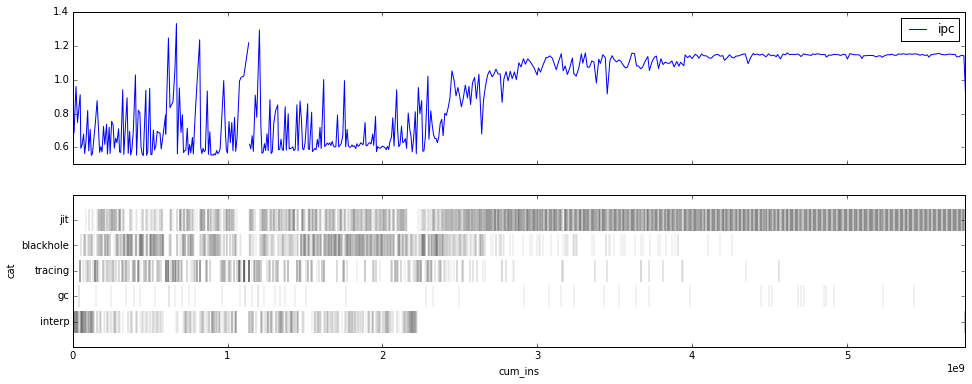

In [82]:
plot_papi_time_breakdown( papi_df, "meteor")

In [83]:
def get_papi_by_phase_df( df ):
    runs = df.groupby("run").first().index
    papi_by_phase_df = None
    for run in runs:
        print run
        tmp_df = plot_papi_time_breakdown( df, run, get_df=True )
        tmp_df = tmp_df.groupby("curr_phase").sum()
        tmp_df["ipc"] = tmp_df["ins"] / tmp_df["cyc"]
        tmp_df["br_per_inst"] = tmp_df["brc"] / tmp_df["ins"]
        tmp_df["br_miss_rate"] = tmp_df["brcm"] / tmp_df["brc"]
        tmp_df["br_mpki"] = tmp_df["brcm"] / tmp_df["ins"] * 1000
        tmp_df["run"] = run
        if papi_by_phase_df is None:
            papi_by_phase_df = tmp_df
        else:
            papi_by_phase_df = papi_by_phase_df.append( tmp_df )
    return papi_by_phase_df

In [84]:
papi_by_phase_df = get_papi_by_phase_df( papi_df )

binarytrees
fannkuchredux
fasta
meteor
nbody
pidigits
regexdna
revcomp
spectralnorm


In [86]:
papi_by_phase_df

,phase,cyc,ins,br,brc,brcm,count,cum_cyc,cum_ins,curr_phase_num,ipc,br_per_inst,br_miss_rate,br_mpki,run
curr_phase,,,,,,,,,,,,,,,
b,18987393,223550399,133986289,28710469,16820117,1248761,18481837205,307552166451900,378306057687306,469887,0.599356,0.125536,0.074242,9.320066,binarytrees
g,923226,15631843190,24652749301,5779166332,4718239832,95232595,1877380674,131891514574226,174243107713989,7514,1.577085,0.191388,0.020184,3.862960,binarytrees
i,10394624,150414836,103467268,22069405,13748078,876003,11272492394,191287220924994,236282289801819,0,0.687879,0.132874,0.063718,8.466475,binarytrees
j,3905830,23773391039,29297017312,3244345885,3129584298,4168375,4337665522,172013823757127,223741206056659,104332,1.232345,0.106823,0.001332,0.142280,binarytrees
t,51957,283699479,293013015,62459859,43199073,2047592,59164600,828567905128,1008068005850,878,1.032829,0.147431,0.047399,6.988058,binarytrees
b,1425512,27262745,14587078,3215216,1833751,144278,261662588,89076059898887,125482826378883,38427,0.535055,0.125711,0.078679,9.890809,fannkuchredux
g,10894602,707881158,433883998,84699053,65296312,3296610,11199142506,56651135458185896,80343458811463616,88574,0.612933,0.150493,0.050487,7.597906,fannkuchredux
i,2734692,77321441,53758218,11632064,7476653,492900,423653890,167175507743006,235847795153922,0,0.695256,0.139079,0.065925,9.168831,fannkuchredux
j,11396976,1278418180367,1815871838021,307465395215,248362937327,10985257633,11275024392,56664590438304616,80362305898861584,368976,1.420405,0.136773,0.044231,6.049578,fannkuchredux


In [87]:
papi_by_phase_df.groupby("curr_phase").mean()

,phase,cyc,ins,br,brc,brcm,count,cum_cyc,cum_ins,curr_phase_num,ipc,br_per_inst,br_miss_rate,br_mpki
curr_phase,,,,,,,,,,,,,,
b,2.798777e+07,5.946797e+08,6.178203e+08,9.908224e+07,8.144500e+07,2.034817e+06,1.755513e+11,1.139290e+15,1.053935e+15,653031.000000,0.700815,0.119924,0.073592,8.887897
g,2.150052e+06,2.119711e+09,3.044529e+09,7.065473e+08,5.780152e+08,1.214864e+07,1.908823e+09,6.942354e+15,9.762504e+15,17482.111111,0.976850,0.188133,0.032175,6.086216
i,1.981207e+07,1.541947e+09,2.207142e+09,3.415127e+08,2.354441e+08,3.410870e+06,6.115575e+10,1.083030e+15,1.086730e+15,0.000000,0.776656,0.128478,0.064733,8.494646
j,1.532139e+07,2.156053e+11,2.958150e+11,4.660904e+10,3.861978e+10,1.283243e+09,6.990704e+10,7.435314e+15,1.021101e+16,429398.666667,1.225590,0.118739,0.018329,2.202316
t,7.586933e+04,2.403628e+08,2.431261e+08,5.271176e+07,3.663895e+07,2.103770e+06,1.615960e+08,1.315672e+12,1.213648e+12,1183.777778,0.996657,0.150285,0.059686,8.985678


In [88]:
papi_by_phase_df.groupby("curr_phase").std()

,phase,cyc,ins,br,brc,brcm,count,cum_cyc,cum_ins,curr_phase_num,ipc,br_per_inst,br_miss_rate,br_mpki
curr_phase,,,,,,,,,,,,,,
b,4.617129e+07,6.659956e+08,1.140018e+09,1.661596e+08,1.646859e+08,3.250100e+06,3.481417e+11,1.670435e+15,1.451314e+15,1.044311e+06,0.597513,0.024218,0.032727,4.504458
g,3.447754e+06,5.076405e+09,8.106295e+09,1.902894e+09,1.553142e+09,3.117377e+07,3.547021e+09,1.866370e+16,2.649521e+16,2.802965e+04,0.332548,0.044600,0.012725,2.950588
i,2.675525e+07,3.215931e+09,5.798068e+09,8.512888e+08,5.998152e+08,4.192668e+06,1.052262e+11,1.875115e+15,1.908735e+15,0.000000e+00,0.421876,0.013028,0.026869,3.615614
j,2.089238e+07,4.084481e+11,5.820266e+11,9.896056e+10,7.977907e+10,3.639849e+09,1.333740e+11,1.847984e+16,2.632796e+16,5.680562e+05,0.115343,0.030858,0.020274,2.650935
t,1.629823e+05,2.906150e+08,3.045436e+08,6.607703e+07,4.587756e+07,2.575528e+06,3.364845e+08,2.222362e+12,2.203296e+12,2.552945e+03,0.112558,0.002819,0.009038,1.502606


In [91]:
papi_by_phase_df.groupby("curr_phase").sem()

,br,br_miss_rate,br_mpki,br_per_inst,brc,brcm,count,cum_cyc,cum_ins,curr_phase_num,cyc,ins,ipc,phase,run
curr_phase,,,,,,,,,,,,,,,
b,5.538654e+07,0.010909,1.501486,0.008073,5.489529e+07,1.083367e+06,1.160472e+11,5.568116e+14,4.837712e+14,348103.682119,2.219985e+08,3.800059e+08,0.199171,1.539043e+07,NaN
g,6.342979e+08,0.004242,0.983529,0.014867,5.177139e+08,1.039126e+07,1.182340e+09,6.221232e+15,8.831738e+15,9343.217972,1.692135e+09,2.702098e+09,0.110849,1.149251e+06,NaN
i,2.837629e+08,0.008956,1.205205,0.004343,1.999384e+08,1.397556e+06,3.507538e+10,6.250385e+14,6.362450e+14,0.000000,1.071977e+09,1.932689e+09,0.140625,8.918417e+06,NaN
j,3.298685e+10,0.006758,0.883645,0.010286,2.659302e+10,1.213283e+09,4.445800e+10,6.159946e+15,8.775985e+15,189352.064683,1.361494e+11,1.940089e+11,0.038448,6.964126e+06,NaN
t,2.202568e+07,0.003013,0.500869,0.000940,1.529252e+07,8.585094e+05,1.121615e+08,7.407874e+11,7.344321e+11,850.981815,9.687165e+07,1.015145e+08,0.037519,5.432742e+04,NaN


## Pin

In [14]:
# List for the imps we use    pypy, pycket
pin_impls = [ ("binarytrees",  2, 1),
              ("fannkuchredux", 6, 1),
              ("fasta",        2, 3),
              ("meteor",       2, 1),
              ("nbody",        2, 2),
              ("pidigits",     2, 1),
              ("revcomp",      6, 2),
              ("spectralnorm", 6, 1)]

In [15]:
def load_pinout( filename, lang, impl, bmark, df ):
    #ext = ".pinout"
    #df = pd.DataFrame()
    #files = os.listdir( data_dir )
    #if valid_runs is None:
    #    valid_runs = map( lambda x: x[:-len(ext)], 
    #                     filter( lambda x: x.endswith(ext), os.listdir(data_dir) ) )

    tmp_df = pd.read_csv( filename )
    tmp_df["bmark"] = bmark
    tmp_df["run"] = "{}_{}".format( bmark, "p" if lang == "pypy" else "r")
    tmp_df["lang"] = lang
    tmp_df["impl"] = impl
    df = df.append( tmp_df, ignore_index=True )
    return df

In [16]:

data_dir = "data/bmarksgame/bm_pin_out_5_24_100B/"
df = pd.DataFrame()
for bmark, pypy_impl, pycket_impl in pin_impls:
    print bmark,
    if pypy_impl == 1:
        filename = "{}/{}.python.pinout".format( data_dir, bmark )
    else:
        filename = "{}/{}.python-{}.python.pinout".format( data_dir, bmark, pypy_impl )
    df = load_pinout( filename, "pypy", pypy_impl, bmark, df )
    if pycket_impl == 1:
        filename = "{}/{}.racket.pinout".format( data_dir, bmark )
    else:
        filename = "{}/{}.racket-{}.racket.pinout".format( data_dir, bmark, pycket_impl )
    df = load_pinout( filename, "pycket", pycket_impl, bmark, df )

binarytrees fannkuchredux fasta meteor nbody pidigits revcomp spectralnorm


In [17]:
bmarksgame_pin_df = df
bmarksgame_pin_df[ bmarksgame_pin_df.type == "c"]

,type,phase,num_bb,num_inst,num_phase_chg,num_phase_chg_phony,addr,call_fun_name,bmark,run,lang,impl
0,c,0,59093,42940931638,222941220,222651272,0,NaN,binarytrees,binarytrees_p,pypy,2
16,c,0,44466,99999899999,88804,68716,0,NaN,binarytrees,binarytrees_r,pycket,1
32,c,0,57381,99999899998,1825142086,1824968928,0,NaN,fannkuchredux,fannkuchredux_p,pypy,6
48,c,0,46777,99999899999,91034,54484,0,NaN,fannkuchredux,fannkuchredux_r,pycket,1
63,c,0,65445,99999900000,953079014,952890276,0,NaN,fasta,fasta_p,pypy,2
80,c,0,52799,38695432582,43389117,43366908,0,NaN,fasta,fasta_r,pycket,3
97,c,0,75974,4007795488,14398287,13198350,0,NaN,meteor,meteor_p,pypy,2
114,c,0,57625,3174217349,312866,112228,0,NaN,meteor,meteor_r,pycket,1
130,c,0,56393,99999899999,1157435981,1157118849,0,NaN,nbody,nbody_p,pypy,2
145,c,0,46249,97308139652,38761,26338,0,NaN,nbody,nbody_r,pycket,2


/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

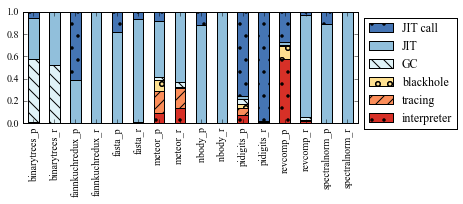

In [22]:
plot_out_dir = "plot_out/"
phases = {
    110: "b",
    120: "G",
    122: "g",
    130: "t",
    132: "T",
    160: "j",
    86:  "j",
    0:   "i",
    10:  "i",
    90:  "C",
    92:  "C",
    94:  "C",
    96:  "C",
    100: "C",
    102: "C",
    104: "C",
    106: "C",
    170: "C"
}

def categorize( r ):
    phase = r.phase
    if phase in phases:
        return phases[ phase ]
    if phase == 83 or phase == 98:
        if r.call_fun_name == "empty":
            return "j"
        else:
            return "c"
    assert False, "unknown phase {}".format( phase )

def plot_pin_jit_phases( pin_df ):
    pin_phase_df = pin_df[ pin_df.type == "p" ]
    pin_phase_df["_category"] = pin_phase_df.apply( categorize, axis=1 )

    category_labels = {
        "i": "0: interpreter",
        "t": "1: tracing",
        "T": "1: tracing",
        "b": "2: blackhole",
        "g": "3: GC",
        "G": "3: GC",
        "j": "4: JIT",
        "c": "5: JIT call",
        "C": "5: JIT call"
    }
    pin_phase_df["category"] = pin_phase_df.apply( lambda r : category_labels[ r._category ], axis=1 )
    pin_phase_df[ "num_inst_ratio" ] = pin_phase_df.apply(
        lambda r: r.num_inst * 1.0 / pin_df[ (pin_df.type == "c") & (pin_df.run == r.run) ].iloc[0].num_inst,
        axis=1 )
    cat_df = pin_phase_df.sort_values( by="category" ).groupby( ["run", "category"] ).sum()
    ax = cat_df.unstack().plot( kind="bar", stacked=True, y="num_inst_ratio", ylim=(0,1.0), 
                                figsize=(6,2),
                                color=['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'])
    num_cols = 16
    hatch_list = [".", "//", "o", "\\\\", " "]
    i = 0
    for p in ax.patches:
        hatch_idx = (i / num_cols) % len( hatch_list )
        p.set_hatch( hatch_list[hatch_idx] )     
        i += 1
    #ax.legend( loc="center left", bbox_to_anchor=(1, 0.5) )
    handles, labels = ax.get_legend_handles_labels()
    ax.xaxis.set_label_text("")
    labels = [ lab[3:] for lab in labels ]
    lgd = ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 1), loc='upper left')
    plt.rc('font',family='Times New Roman')
    #ax.legend( loc="center left", bbox_to_anchor=(1, 0.5) )
    output_file = plot_out_dir + "fig-bmarksgame-phase-by-bmark" + ".svg"
    fig = ax.get_figure()
    #fig.tight_layout()
    fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
plot_pin_jit_phases( bmarksgame_pin_df )

In [206]:
def find_significant_aot_funs( pin_df, threshold=10.0 ):
    # Loop over the benchmarks if any of them occupy a certain percentage.
    #threshold = 10.0 # 10%
    # Contains tuples of (bmark, percent, function)
    fun_table = []
    runs = pin_df.groupby("run").first().index
    for run in runs:
    #run = "meteor-contest"
        print run
        run_df = pin_df[ pin_df.run == run ]

        run_df_c = run_df[ pin_df.type == "c" ].iloc[0]
        num_inst = run_df_c.num_inst
        call_df = run_df[ ( ( run_df.phase == 83 ) | ( run_df.phase == 98 ) ) & ( run_df.call_fun_name != "empty" ) ]
        call_df[ "num_inst_ratio" ] = call_df.num_inst * 100.0 / num_inst
        call_df = call_df.groupby( "call_fun_name" ).sum().sort_values( by="num_inst", ascending=False )
        call_df = call_df[ call_df.num_inst_ratio >= threshold ]


        for fun_name, r in call_df.iterrows():
            fun_table.append( (run, r.num_inst_ratio, fun_name) )

    return fun_table

find_significant_aot_funs( bmarksgame_pin_df, threshold=1.0 )

binarytrees_p
binarytrees_r
fannkuchredux_p
fannkuchredux_r
fasta_p
fasta_r


/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/berkin/work/venvs/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


meteor_p
meteor_r
nbody_p
nbody_r
pidigits_p
pidigits_r
revcomp_p
revcomp_r
spectralnorm_p
spectralnorm_r


[]